<a href="https://colab.research.google.com/github/KeoJ/CIND820/blob/main/LSTM_Multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


In [75]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [100]:
# load dataset
btc_twitter = pd.read_csv('/btc_twitter.csv')
values = btc_twitter.values

# constants for model
n_days = 2
n_features = 2
n_obs = n_days * n_features

In [101]:
# scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [102]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [103]:
# split into train and test sets
values = reframed.values
train = values[998:2093, :]
test = values[2093:2143, :]

# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1095, 2, 2) (1095,) (50, 2, 2) (50,)


In [104]:
# design network
model = Sequential()
model.add(LSTM(units = 50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/100
35/35 - 3s - loss: 0.0368 - val_loss: 0.0187
Epoch 2/100
35/35 - 0s - loss: 0.0520 - val_loss: 0.0492
Epoch 3/100
35/35 - 0s - loss: 0.0397 - val_loss: 0.0156
Epoch 4/100
35/35 - 0s - loss: 0.0437 - val_loss: 0.0409
Epoch 5/100
35/35 - 0s - loss: 0.0313 - val_loss: 0.0082
Epoch 6/100
35/35 - 0s - loss: 0.0307 - val_loss: 0.0068
Epoch 7/100
35/35 - 0s - loss: 0.0253 - val_loss: 0.0036
Epoch 8/100
35/35 - 0s - loss: 0.0174 - val_loss: 0.0055
Epoch 9/100
35/35 - 0s - loss: 0.0088 - val_loss: 0.0047
Epoch 10/100
35/35 - 0s - loss: 0.0158 - val_loss: 0.0050
Epoch 11/100
35/35 - 0s - loss: 0.0068 - val_loss: 0.0029
Epoch 12/100
35/35 - 0s - loss: 0.0043 - val_loss: 0.0037
Epoch 13/100
35/35 - 0s - loss: 0.0091 - val_loss: 0.0079
Epoch 14/100
35/35 - 0s - loss: 0.0109 - val_loss: 0.0039
Epoch 15/100
35/35 - 0s - loss: 0.0050 - val_loss: 0.0076
Epoch 16/100
35/35 - 0s - loss: 0.0186 - val_loss: 0.0087
Epoch 17/100
35/35 - 0s - loss: 0.0102 - val_loss: 0.0039
Epoch 18/100
35/35 - 0s

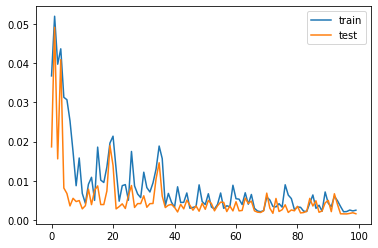

In [105]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [106]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days* n_features,))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

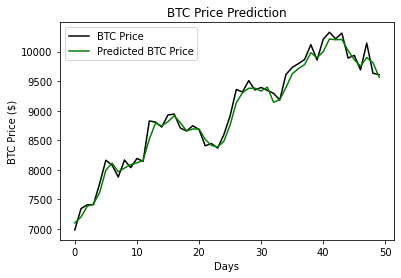

In [110]:
# plot the results
plt.plot(inv_y, color = 'black', label='BTC Price')
plt.plot(inv_yhat, color = 'green', label='Predicted BTC Price')
plt.title('BTC Price Prediction')
plt.xlabel('Days')
plt.ylabel('BTC Price ($)')
plt.legend()
plt.show()


In [112]:
# MSE & RMSE calcualtion
mse = (mean_squared_error(inv_y, inv_yhat))
print('MSE: %.3f' % mse)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('RMSE: %.3f' % rmse)

MSE: 13396.722
RMSE: 115.744
